In [2]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import random
import os

from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import *
from tensorflow.keras.callbacks import *

In [6]:
### LOAD TRAIN ###
train_df = pd.read_csv('train_FD001.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']
print('#id:',len(train_df.id.unique()))
train_df = train_df.sort_values(['id','cycle'])
print(train_df.shape)
train_df.head(3)

#id: 100
(20631, 26)


,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442


medium working time: 206.31
max working time: 362
min working time: 128


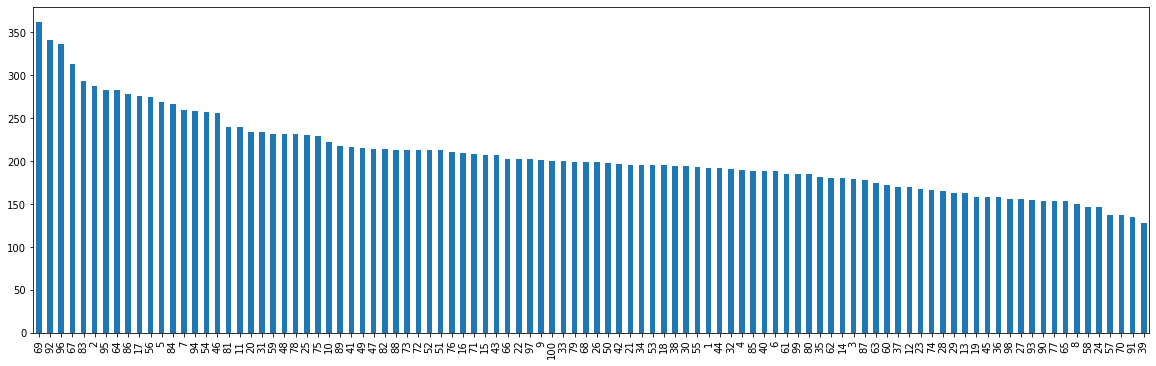

In [5]:
### PLOT TRAIN FREQ ###
plt.figure(figsize=(20,6))
train_df.id.value_counts().plot.bar()
print("medium working time:", train_df.id.value_counts().mean())
print("max working time:", train_df.id.value_counts().max())
print("min working time:", train_df.id.value_counts().min())

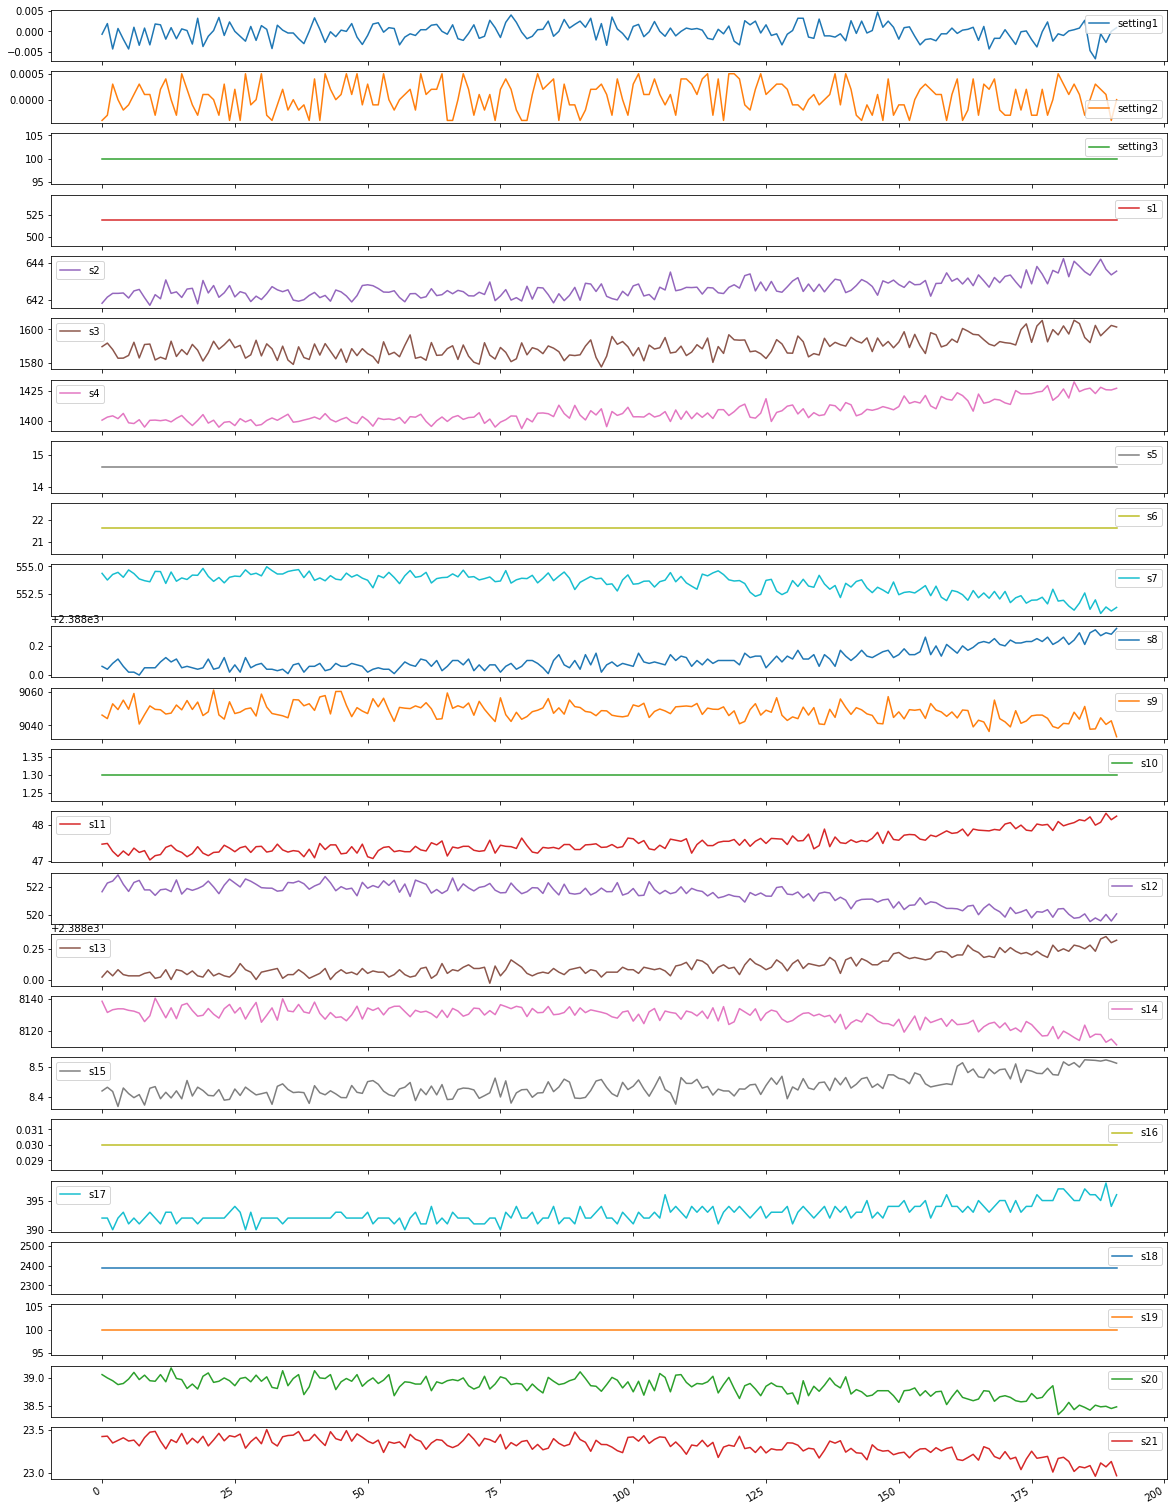

In [7]:
### plotting sensor data for engine ID ###
engine_id = train_df[train_df['id'] == 1]

ax1 = engine_id[train_df.columns[2:]].plot(subplots=True, sharex=True, figsize=(20,30))

In [52]:
### LOAD TEST ###
test_df = pd.read_csv('test_FD001.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']
print('#id:',len(test_df.id.unique()))
print(test_df.shape)
test_df.head(3)

#id: 100
(13096, 26)


,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166


In [4]:
### LOAD GROUND TRUTH ###
truth_df = pd.read_csv('RUL_FD001.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)
truth_df.columns = ['more']
truth_df = truth_df.set_index(truth_df.index + 1)

print(truth_df.shape)
truth_df.head(3)

(100, 1)


,more
1,112
2,98
3,69


In [7]:
### CALCULATE RUL TRAIN ###
train_df['RUL']=train_df.groupby(['id'])['cycle'].transform(max)-train_df['cycle']
train_df.RUL[0:10]

0    191
1    190
2    189
3    188
4    187
5    186
6    185
7    184
8    183
9    182
Name: RUL, dtype: int64

In [9]:
max_cycles = train_df.groupby('id')['cycle'].max()
for i in range(10):
    print("Total Lifetime {} percentile: ".format(i/10.0), max_cycles.quantile(q=i/10.0))

Total Lifetime 0.0 percentile:  128.0
Total Lifetime 0.1 percentile:  154.9
Total Lifetime 0.2 percentile:  167.6
Total Lifetime 0.3 percentile:  183.79999999999998
Total Lifetime 0.4 percentile:  192.6
Total Lifetime 0.5 percentile:  199.0
Total Lifetime 0.6 percentile:  207.4
Total Lifetime 0.7 percentile:  214.3
Total Lifetime 0.8 percentile:  234.0
Total Lifetime 0.9 percentile:  275.1


In [10]:
for i in range(10):
    print("RUL {} percentile: ".format(i/10.0), train_df.RUL.quantile(q=i/10.0))

RUL 0.0 percentile:  0.0
RUL 0.1 percentile:  20.0
RUL 0.2 percentile:  41.0
RUL 0.3 percentile:  61.0
RUL 0.4 percentile:  82.0
RUL 0.5 percentile:  103.0
RUL 0.6 percentile:  123.0
RUL 0.7 percentile:  144.0
RUL 0.8 percentile:  168.0
RUL 0.9 percentile:  198.0


## Comments

* Business justification for binning via strict RUL's because it prioritizes identifying dire engines that are right at the point of failure

* Artificially skewed our dataset because units with a longer lifespan have disproportional influence on the model. 

In [11]:
### ADD NEW LABEL TRAIN ###
w1 = 45
w0 = 15
w = [200,175,150,125,100,75,50,40,30,25,20,15,10,5]

train_df['label'] = np.where(train_df['RUL'] <= w[0], 1, 0 )
for i in range(1,len(w)):
    train_df.loc[train_df['RUL'] <= w[i], 'label'] = i+1

In [12]:
len(train_df[train_df.RUL > 200])

1958

In [13]:
len(train_df[(train_df.RUL > 175) &
            (train_df.RUL<=200)])

1579

In [14]:
train_df.label.value_counts()

6     2500
5     2500
4     2500
3     2424
2     2070
0     1958
1     1579
8     1000
7     1000
14     600
13     500
12     500
11     500
10     500
9      500
Name: label, dtype: int64

In [15]:
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,RUL,label
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,1
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,1
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,1
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,1
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,1


In [36]:
train_df[train_df.id==1].head()

,id,cycle,setting1,setting2,s2,s3,s4,s6,s7,s8,...,s12,s13,s14,s15,s17,s20,s21,RUL,label1,label2
0,1,1,0.459770,0.166667,0.183735,0.406802,0.309757,1.0,0.726248,0.242424,...,0.633262,0.205882,0.199608,0.363986,0.333333,0.713178,0.724662,191,0,0
1,1,2,0.609195,0.250000,0.283133,0.453019,0.352633,1.0,0.628019,0.212121,...,0.765458,0.279412,0.162813,0.411312,0.333333,0.666667,0.731014,190,0,0
2,1,3,0.252874,0.750000,0.343373,0.369523,0.370527,1.0,0.710145,0.272727,...,0.795309,0.220588,0.171793,0.357445,0.166667,0.627907,0.621375,189,0,0
3,1,4,0.540230,0.500000,0.343373,0.256159,0.331195,1.0,0.740741,0.318182,...,0.889126,0.294118,0.174889,0.166603,0.333333,0.573643,0.662386,188,0,0
4,1,5,0.390805,0.333333,0.349398,0.257467,0.404625,1.0,0.668277,0.242424,...,0.746269,0.235294,0.174734,0.402078,0.416667,0.589147,0.704502,187,0,0


In [35]:
train_df[train_df.id==1].tail(20)

,id,cycle,setting1,setting2,s2,s3,s4,s6,s7,s8,...,s12,s13,s14,s15,s17,s20,s21,RUL,label1,label2
172,1,173,0.316092,0.666667,0.530120,0.428385,0.726199,1.0,0.367150,0.484848,...,0.302772,0.514706,0.111983,0.708734,0.583333,0.348837,0.393123,19,1,1
173,1,174,0.494253,0.333333,0.430723,0.627207,0.680790,1.0,0.397746,0.484848,...,0.326226,0.485294,0.099236,0.472105,0.416667,0.333333,0.195388,18,1,1
174,1,175,0.505747,0.666667,0.722892,0.703074,0.679777,1.0,0.288245,0.500000,...,0.360341,0.500000,0.133244,0.631397,0.500000,0.341085,0.363297,17,1,1
175,1,176,0.385057,0.250000,0.496988,0.462830,0.683322,1.0,0.331723,0.500000,...,0.236674,0.470588,0.123129,0.617160,0.500000,0.449612,0.490058,16,1,1
176,1,177,0.281609,0.250000,0.777108,0.675387,0.704591,1.0,0.334944,0.530303,...,0.330490,0.514706,0.104087,0.588688,0.666667,0.379845,0.377106,15,1,2
177,1,178,0.494253,0.666667,0.653614,0.747547,0.715733,1.0,0.375201,0.500000,...,0.321962,0.470588,0.085767,0.585225,0.583333,0.395349,0.390500,14,1,2
178,1,179,0.632184,0.250000,0.496988,0.469152,0.796759,1.0,0.276973,0.545455,...,0.360341,0.441176,0.087212,0.653328,0.583333,0.488372,0.406794,13,1,2
179,1,180,0.362069,0.500000,0.713855,0.628515,0.588960,1.0,0.492754,0.469697,...,0.245203,0.588235,0.116782,0.572528,0.583333,0.558140,0.155758,12,1,2
180,1,181,0.465517,0.916667,0.671687,0.559625,0.648042,1.0,0.318841,0.500000,...,0.371002,0.514706,0.076633,0.565987,0.750000,0.155039,0.374206,11,1,2
181,1,182,0.442529,0.750000,0.903614,0.676695,0.748987,1.0,0.330113,0.545455,...,0.377399,0.544118,0.101816,0.734513,0.750000,0.224806,0.392847,10,1,2


In [16]:
### SCALE TRAIN DATA ###

def scale(df):
    #return (df - df.mean())/df.std()
    return (df - df.min())/(df.max()-df.min())

for col in train_df.columns:
    if col[0] == 's':
        train_df[col] = scale(train_df[col])
#     elif col == 'cycle':
#         train_df['cycle_norm'] = scale(train_df[col])
        
train_df = train_df.dropna(axis=1)
train_df.head()

,id,cycle,setting1,setting2,s2,s3,s4,s6,s7,s8,...,s11,s12,s13,s14,s15,s17,s20,s21,RUL,label
0,1,1,0.459770,0.166667,0.183735,0.406802,0.309757,1.0,0.726248,0.242424,...,0.369048,0.633262,0.205882,0.199608,0.363986,0.333333,0.713178,0.724662,191,1
1,1,2,0.609195,0.250000,0.283133,0.453019,0.352633,1.0,0.628019,0.212121,...,0.380952,0.765458,0.279412,0.162813,0.411312,0.333333,0.666667,0.731014,190,1
2,1,3,0.252874,0.750000,0.343373,0.369523,0.370527,1.0,0.710145,0.272727,...,0.250000,0.795309,0.220588,0.171793,0.357445,0.166667,0.627907,0.621375,189,1
3,1,4,0.540230,0.500000,0.343373,0.256159,0.331195,1.0,0.740741,0.318182,...,0.166667,0.889126,0.294118,0.174889,0.166603,0.333333,0.573643,0.662386,188,1
4,1,5,0.390805,0.333333,0.349398,0.257467,0.404625,1.0,0.668277,0.242424,...,0.255952,0.746269,0.235294,0.174734,0.402078,0.416667,0.589147,0.704502,187,1


In [17]:
truth_df.head()

,more
1,112
2,98
3,69
4,82
5,91


In [18]:
### CALCULATE RUL TEST ###
truth_df['max'] = test_df.groupby('id')['cycle'].max() + truth_df['more']
test_df['RUL'] = [truth_df['max'][i] for i in test_df.id] - test_df['cycle']

In [19]:
truth_df.head()

,more,max
1,112,143
2,98,147
3,69,195
4,82,188
5,91,189


In [20]:
### ADD NEW LABEL TEST ###
# test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
# test_df['label2'] = test_df['label1']
# test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2

test_df['label'] = np.where(test_df['RUL'] <= w[0], 1, 0 )
for i in range(1,len(w)):
    test_df.loc[test_df['RUL'] <= w[i], 'label'] = i+1

In [21]:
test_df.label.nunique()

14

In [22]:
train_df.label.nunique()

15

In [23]:
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,RUL,label
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,142,3
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,141,3
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,140,3
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,139,3
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,138,3


In [24]:
test_df.label.value_counts()

3     2363
2     2078
0     1959
4     1950
1     1552
5     1335
6      973
7      290
8      264
9      114
10      95
11      63
12      43
13      17
Name: label, dtype: int64

In [25]:
### SCALE TEST DATA ###

for col in test_df.columns:
    if col[0] == 's':
        test_df[col] = scale(test_df[col])
#     elif col == 'cycle':
#         test_df['cycle_norm'] = scale(test_df[col])
        
test_df = test_df.dropna(axis=1)
test_df.head()

,id,cycle,setting1,setting2,s2,s3,s4,s6,s7,s8,...,s11,s12,s13,s14,s15,s17,s20,s21,RUL,label
0,1,1,0.65625,0.692308,0.596215,0.421968,0.282214,1.0,0.608871,0.365854,...,0.273973,0.534247,0.325581,0.152259,0.347076,0.375,0.500000,0.620099,142,3
1,1,2,0.34375,0.230769,0.182965,0.504025,0.225240,1.0,0.800403,0.292683,...,0.479452,0.634703,0.395349,0.277907,0.227709,0.500,0.645455,0.645718,141,3
2,1,3,0.53125,0.538462,0.419558,0.464814,0.346130,1.0,0.651210,0.390244,...,0.479452,0.591324,0.325581,0.192892,0.533557,0.500,0.700000,0.681104,140,3
3,1,4,0.77500,0.461538,0.413249,0.391587,0.449867,1.0,0.643145,0.341463,...,0.328767,0.456621,0.372093,0.217896,0.282359,0.250,0.627273,0.620382,139,3
4,1,5,0.60000,0.461538,0.435331,0.471306,0.357974,1.0,0.661290,0.292683,...,0.349315,0.632420,0.325581,0.187891,0.337009,0.125,0.618182,0.676008,138,3


# GEN SEQUENCE

In [26]:
sequence_length = 50

def gen_sequence(id_df, seq_length, seq_cols):

    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    # Iterate over two lists in parallel.
    # For example id1 have 192 rows and sequence_length is equal to 50
    # so zip iterate over two following list of numbers (0,142),(50,192)
    # 0 50 (start stop) -> from row 0 to row 50
    # 1 51 (start stop) -> from row 1 to row 51
    # 2 52 (start stop) -> from row 2 to row 52
    # ...
    # 141 191 (start stop) -> from row 141 to 191
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]
        
def gen_labels(id_df, seq_length, label):

    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    # I have to remove the first seq_length labels
    # because for one id the first sequence of seq_length size have as target
    # the last label (the previus ones are discarded).
    # All the next id's sequences will have associated step by step one label as target.
    return data_matrix[seq_length:num_elements, :]

In [27]:
### SEQUENCE COL: COLUMNS TO CONSIDER ###
sequence_cols = []
for col in train_df.columns:
    if col[0] == 's':
        sequence_cols.append(col)
#sequence_cols.append('cycle_norm')
print(sequence_cols)

['setting1', 'setting2', 's2', 's3', 's4', 's6', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20', 's21']


In [28]:
### GENERATE X TRAIN TEST ###
x_train, x_test = [], []
for engine_id in train_df.id.unique():
    for sequence in gen_sequence(train_df[train_df.id==engine_id], sequence_length, sequence_cols):
        x_train.append(sequence)
    for sequence in gen_sequence(test_df[test_df.id==engine_id], sequence_length, sequence_cols):
        x_test.append(sequence)
    
x_train = np.asarray(x_train)
x_test = np.asarray(x_test)

print("X_Train shape:", x_train.shape)
print("X_Test shape:", x_test.shape)

X_Train shape: (15631, 50, 17)
X_Test shape: (8162, 50, 17)


In [29]:
### GENERATE Y TRAIN TEST ###
y_train, y_test = [], []
for engine_id in train_df.id.unique():
    for label in gen_labels(train_df[train_df.id==engine_id], sequence_length, ['label'] ):
        y_train.append(label)
    for label in gen_labels(test_df[test_df.id==engine_id], sequence_length, ['label']):
        y_test.append(label)
    
y_train = np.asarray(y_train).reshape(-1,1)
y_test = np.asarray(y_test).reshape(-1,1)


print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (15631, 1)
y_test shape: (8162, 1)


In [30]:
### ENCODE LABEL ###
y_train = to_categorical(y_train)
print(y_train.shape)

y_test = to_categorical(y_test)
print(y_test.shape)

(15631, 15)
(8162, 14)


# FROM TIME SERIES TO IMAGES

In [31]:
def rec_plot(s, eps=0.10, steps=10):
    d = pdist(s[:,None])
    d = np.floor(d/eps)
    d[d>steps] = steps
    Z = squareform(d)
    return Z

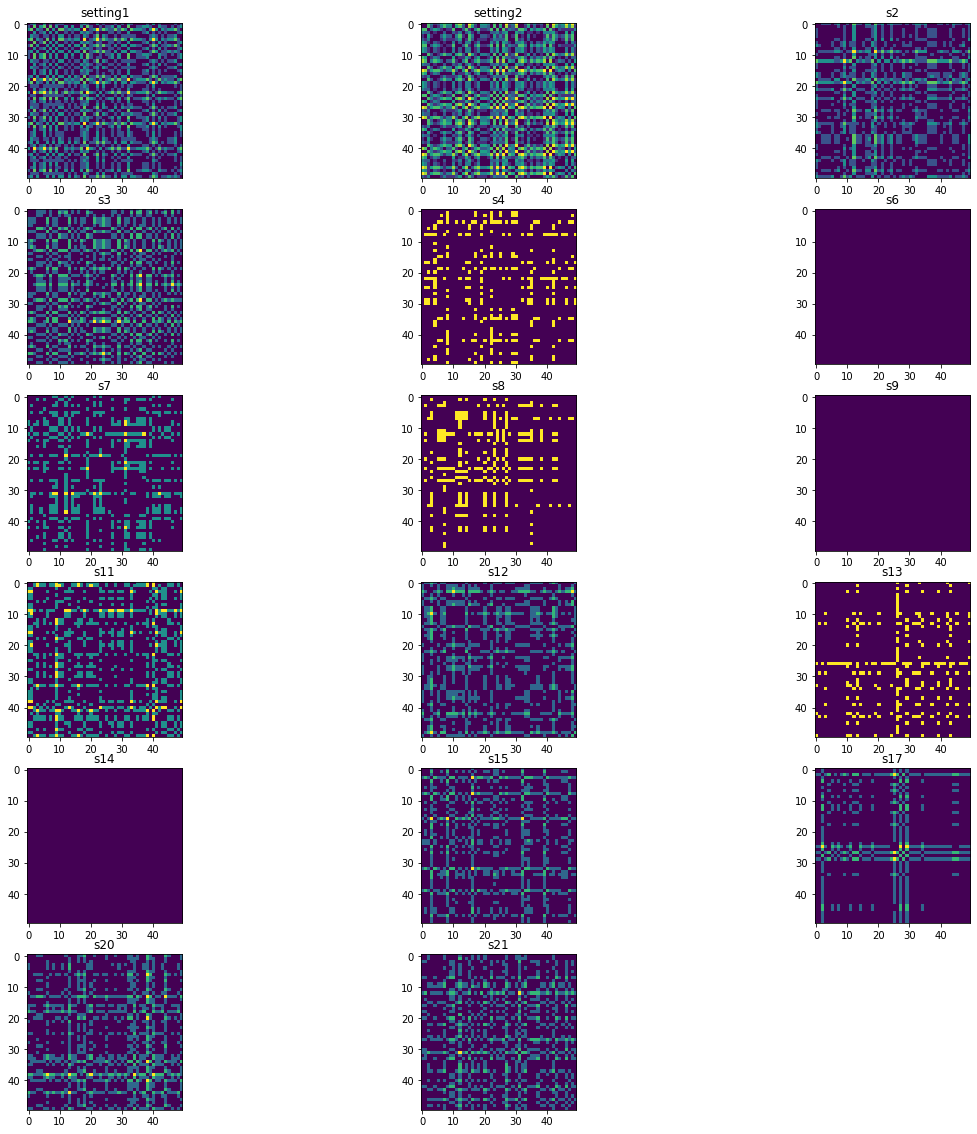

In [32]:
plt.figure(figsize=(20,20))
for i in range(0,17):
    
    plt.subplot(6, 3, i+1)    
    rec = rec_plot(x_train[0,:,i])
    plt.imshow(rec)
    plt.title(sequence_cols[i])
plt.show()

In [33]:
### TRANSFORM X TRAIN TEST IN IMAGES ###
x_train_img = np.apply_along_axis(rec_plot, 1, x_train).astype('float16')
print(x_train_img.shape)

x_test_img = np.apply_along_axis(rec_plot, 1, x_test).astype('float16')
print(x_test_img.shape)

(15631, 50, 50, 17)
(8162, 50, 50, 17)


# MODEL

In [62]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(50, 50, 17)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(15, activation='softmax'))

#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 48, 48, 32)        4928      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 46, 46, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 19, 19, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 9, 9, 64)         

In [63]:
### SET SEED ###
tf.random.set_seed(33)
os.environ['PYTHONHASHSEED'] = str(33)
np.random.seed(33)
random.seed(33)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)


es = EarlyStopping(monitor='val_accuracy', mode='auto', restore_best_weights=True, verbose=1, patience=6)

model.fit(x_train_img, y_train, batch_size=512, epochs=25, callbacks=[es],
          validation_split=0.2, verbose=2)

Epoch 1/25
25/25 - 49s - loss: 2.5747 - accuracy: 0.1495 - val_loss: 2.5377 - val_accuracy: 0.1500
Epoch 2/25
25/25 - 48s - loss: 2.3345 - accuracy: 0.1774 - val_loss: 2.3388 - val_accuracy: 0.1551
Epoch 3/25
25/25 - 49s - loss: 2.0633 - accuracy: 0.2302 - val_loss: 2.1160 - val_accuracy: 0.2242
Epoch 4/25
25/25 - 48s - loss: 1.9311 - accuracy: 0.2627 - val_loss: 2.0458 - val_accuracy: 0.2335
Epoch 5/25
25/25 - 48s - loss: 1.8029 - accuracy: 0.2941 - val_loss: 1.9261 - val_accuracy: 0.2590
Epoch 6/25
25/25 - 48s - loss: 1.6964 - accuracy: 0.3269 - val_loss: 2.0585 - val_accuracy: 0.2670
Epoch 7/25
25/25 - 48s - loss: 1.6379 - accuracy: 0.3447 - val_loss: 1.8989 - val_accuracy: 0.2971
Epoch 8/25
25/25 - 48s - loss: 1.5488 - accuracy: 0.3700 - val_loss: 2.0595 - val_accuracy: 0.2773
Epoch 9/25
25/25 - 48s - loss: 1.4882 - accuracy: 0.3972 - val_loss: 1.8940 - val_accuracy: 0.2776
Epoch 10/25
25/25 - 48s - loss: 1.4117 - accuracy: 0.4241 - val_loss: 1.9626 - val_accuracy: 0.2942
Epoch 11/

In [27]:
model.evaluate(x_test_img, y_test, verbose=2)

256/256 - 6s - loss: 1.4270 - accuracy: 0.4990


[1.4269553422927856, 0.4990198612213135]

In [34]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

In [65]:
print(classification_report(np.where(y_test != 0)[1], model.predict_classes(x_test_img)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       512
           1       0.00      0.00      0.00       542
           2       0.00      0.00      0.00       905
           3       0.27      0.35      0.31      1471
           4       0.20      0.14      0.16      1569
           5       0.11      0.00      0.00      1304
           6       0.16      0.66      0.26       973
           7       0.14      0.09      0.11       290
           8       0.19      0.11      0.14       264
           9       0.05      0.01      0.01       114
          10       0.00      0.00      0.00        95
          11       0.00      0.00      0.00        63
          12       0.00      0.00      0.00        43
          13       0.00      0.00      0.00        17
          14       0.00      0.00      0.00         0

    accuracy                           0.18      8162
   macro avg       0.07      0.09      0.07      8162
weighted avg       0.13   

/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [67]:
w[10]

20

<ipython-input-28-28e7e30823f4>:3: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


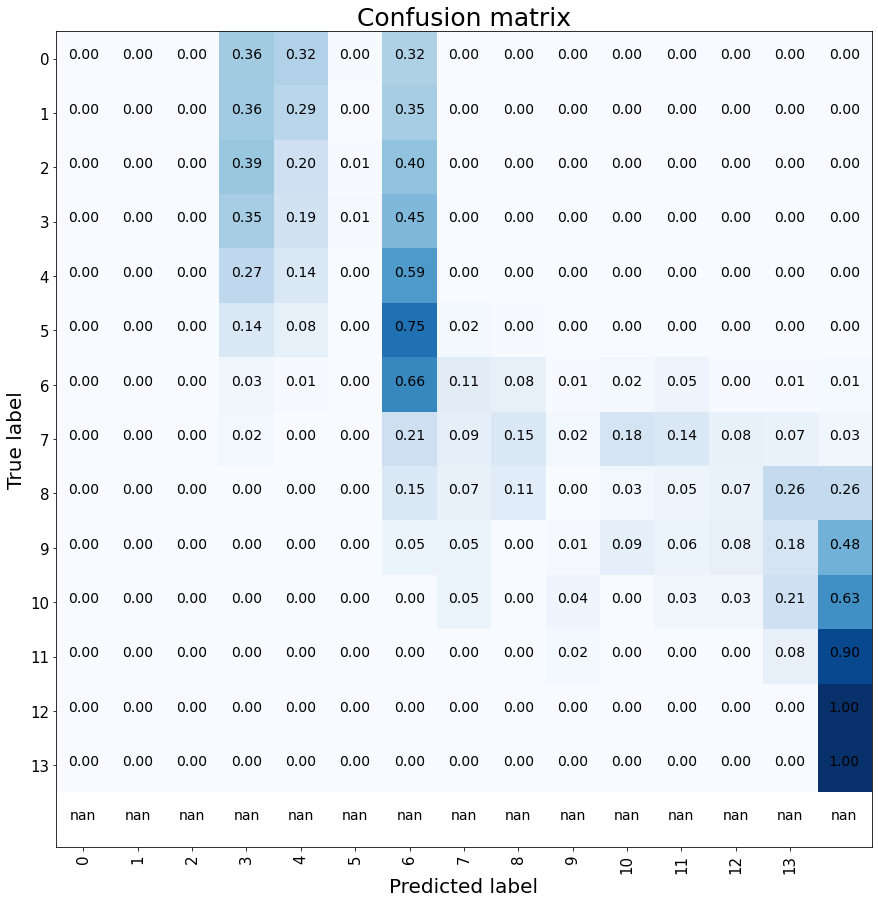

In [66]:
cnf_matrix = confusion_matrix(np.where(y_test != 0)[1], model.predict_classes(x_test_img))
plt.figure(figsize=(15,15))
plot_confusion_matrix(cnf_matrix, classes=np.unique(np.where(y_test != 0)[1]), title="Confusion matrix")
plt.show()

## Cache the Model Object for Future Reference

https://keras.io/api/models/model_saving_apis/

In [68]:
model.save('ClassifierV1.h5')

## Saving the Category Cutoffs

In [69]:
w

[200, 175, 150, 125, 100, 75, 50, 40, 30, 25, 20, 15, 10, 5]

In [ ]:
import pickle

with open('category_cutoffs_V1_and_V2.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(w, f, pickle.HIGHEST_PROTOCOL)

## Investigate Label Smoothing ala Rich
https://www.tensorflow.org/api_docs/python/tf/keras/losses/categorical_crossentropy

```label_smoothing=0```

<ipython-input-28-28e7e30823f4>:3: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


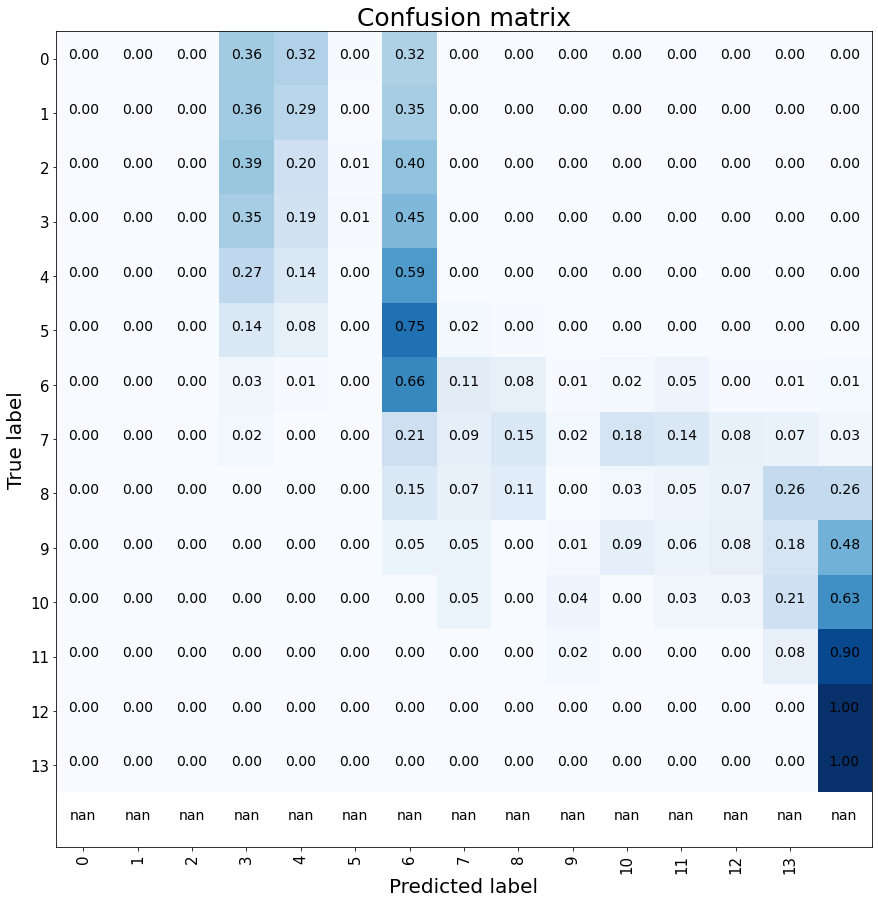

In [72]:
cnf_matrix = confusion_matrix(np.where(y_test != 0)[1], model.predict_classes(x_test_img))
plt.figure(figsize=(15,15))
plot_confusion_matrix(cnf_matrix, classes=np.unique(np.where(y_test != 0)[1]), title="Confusion matrix")
i = 0
plt.savefig('Confusion_matrix_smoothing_{}.png'.format(i))

In [35]:
smooth = [0.001, 0.01, 0.1, 0.25, 0.5, 0.8, 0.9, 0.99, 0.999]

In [36]:
def generate_model(smoothing_coef):
    
    file_name_suffix = str(smoothing_coef)[1:].replace('.','')
    
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(50, 50, 17)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(15, activation='softmax'))

    #sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=smoothing_coef)

    model.compile(loss=loss, optimizer='adam', metrics=['accuracy'])

    #print(model.summary())

    ### SET SEED ###
    tf.random.set_seed(33)
    os.environ['PYTHONHASHSEED'] = str(33)
    np.random.seed(33)
    random.seed(33)

    session_conf = tf.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1, 
        inter_op_parallelism_threads=1
    )
    sess = tf.compat.v1.Session(
        graph=tf.compat.v1.get_default_graph(), 
        config=session_conf
    )
    tf.compat.v1.keras.backend.set_session(sess)


    es = EarlyStopping(monitor='val_accuracy', mode='auto', restore_best_weights=True, verbose=1, patience=6)

    model.fit(x_train_img, y_train, batch_size=512, epochs=10, callbacks=[es],
              validation_split=0.2, verbose=2)
    
    model.save('ClassifierV2_Smoothing{}.h5'.format(file_name_suffix))

    cnf_matrix = confusion_matrix(np.where(y_test != 0)[1], model.predict_classes(x_test_img))
    plt.figure(figsize=(15,15))
    plot_confusion_matrix(cnf_matrix, classes=np.unique(np.where(y_test != 0)[1]), title="Confusion matrix")
    plt.savefig('Confusion_matrix_smoothing_{}.png'.format(file_name_suffix))

In [37]:
smooth[4]

0.5

In [ ]:
for s in smooth[4:]:
    generate_model(s)

Epoch 1/10
25/25 - 49s - loss: 2.7223 - accuracy: 0.1412 - val_loss: 2.6761 - val_accuracy: 0.1532
Epoch 2/10
25/25 - 48s - loss: 2.6401 - accuracy: 0.1754 - val_loss: 2.6485 - val_accuracy: 0.1727
Epoch 3/10
25/25 - 47s - loss: 2.6028 - accuracy: 0.1887 - val_loss: 2.6137 - val_accuracy: 0.1727
Epoch 4/10
25/25 - 48s - loss: 2.5631 - accuracy: 0.2331 - val_loss: 2.5773 - val_accuracy: 0.2347
Epoch 5/10
25/25 - 47s - loss: 2.5318 - accuracy: 0.2740 - val_loss: 2.5533 - val_accuracy: 0.2689
Epoch 6/10
25/25 - 47s - loss: 2.5098 - accuracy: 0.3019 - val_loss: 2.5456 - val_accuracy: 0.2555
Epoch 7/10
25/25 - 47s - loss: 2.4945 - accuracy: 0.3216 - val_loss: 2.5374 - val_accuracy: 0.2731
Epoch 8/10
25/25 - 48s - loss: 2.4839 - accuracy: 0.3331 - val_loss: 2.5684 - val_accuracy: 0.2673
Epoch 9/10
25/25 - 48s - loss: 2.4669 - accuracy: 0.3660 - val_loss: 2.5239 - val_accuracy: 0.2837
Epoch 10/10
25/25 - 48s - loss: 2.4502 - accuracy: 0.3892 - val_loss: 2.5114 - val_accuracy: 0.3025


## Loading a Model

In [38]:
from keras.models import load_model

In [41]:
w[7]

40

In [39]:
model = load_model('ClassifierV2_Smoothing5.h5')

In [ ]:
smooth_

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<ipython-input-34-28e7e30823f4>:3: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


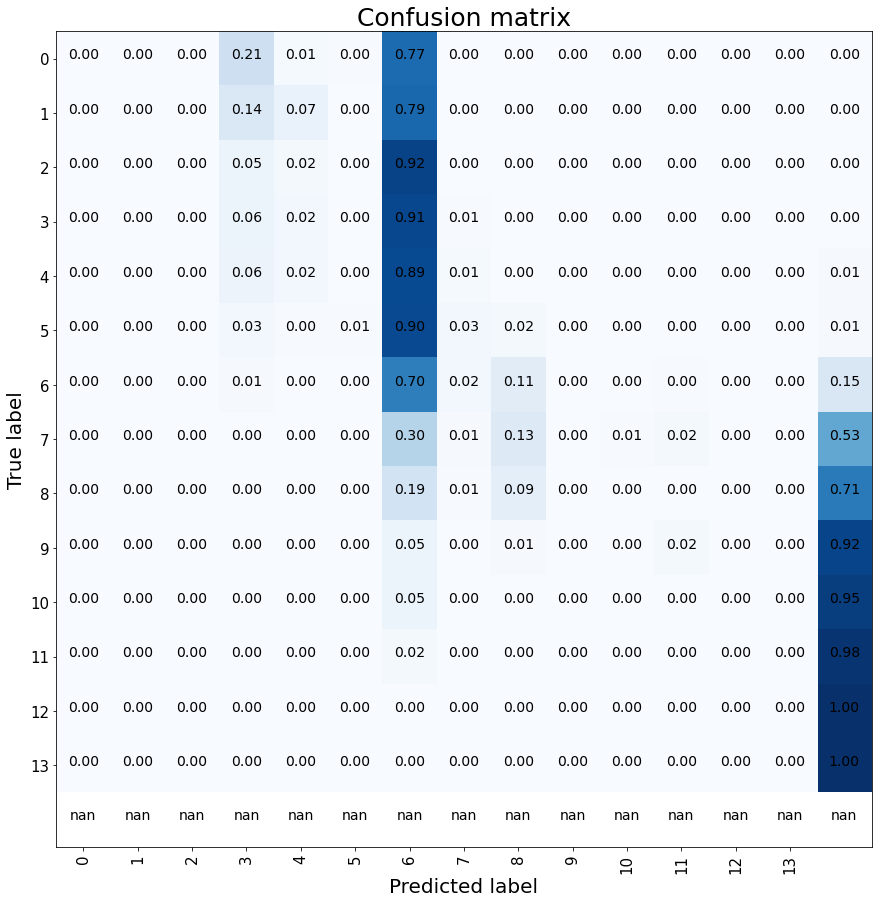

In [40]:
smoothing_coef = 0.5
file_name_suffix = str(smoothing_coef)[1:].replace('.','')
cnf_matrix = confusion_matrix(np.where(y_test != 0)[1], model.predict_classes(x_test_img))
plt.figure(figsize=(15,15))
plot_confusion_matrix(cnf_matrix, classes=np.unique(np.where(y_test != 0)[1]), title="Confusion matrix")
plt.savefig('Confusion_matrix_smoothing_{}.png'.format(file_name_suffix))

## Reduce Number of Buckets ala Luke

## Impact of Window Size

In [ ]:
window_sizes = [10,20,30,40,50,60,70,80,90,100]

In [43]:
test_df.head()

,id,cycle,setting1,setting2,s2,s3,s4,s6,s7,s8,...,s11,s12,s13,s14,s15,s17,s20,s21,RUL,label
0,1,1,0.65625,0.692308,0.596215,0.421968,0.282214,1.0,0.608871,0.365854,...,0.273973,0.534247,0.325581,0.152259,0.347076,0.375,0.500000,0.620099,142,3
1,1,2,0.34375,0.230769,0.182965,0.504025,0.225240,1.0,0.800403,0.292683,...,0.479452,0.634703,0.395349,0.277907,0.227709,0.500,0.645455,0.645718,141,3
2,1,3,0.53125,0.538462,0.419558,0.464814,0.346130,1.0,0.651210,0.390244,...,0.479452,0.591324,0.325581,0.192892,0.533557,0.500,0.700000,0.681104,140,3
3,1,4,0.77500,0.461538,0.413249,0.391587,0.449867,1.0,0.643145,0.341463,...,0.328767,0.456621,0.372093,0.217896,0.282359,0.250,0.627273,0.620382,139,3
4,1,5,0.60000,0.461538,0.435331,0.471306,0.357974,1.0,0.661290,0.292683,...,0.349315,0.632420,0.325581,0.187891,0.337009,0.125,0.618182,0.676008,138,3


In [45]:
min(test_df.groupby('id')['cycle'].max())

31

In [51]:
test_df[test_df.id==1][['RUL', 'label']]

,RUL,label
0,142,3
1,141,3
2,140,3
3,139,3
4,138,3
5,137,3
6,136,3
7,135,3
8,134,3
9,133,3


## Dashboard Use Cases / Components

* Comparing Enginges / Run Model against Specific Enginge ID
    * Drop-down for selecting enginges 
* Project mission rediness of enginges
* Cost of maintaining fleet / jets

* Looking for changing rates of degredation (finding the elbow of the curve)
    * Interplay with model drift / Challenge 4



## Additional To Do's / Thoughts

* Hierarchical / mixed effect modeling documentation